In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from pprint import pprint


In [2]:
def get_nodes(dataframe):
    return np.count_nonzero(dataframe["demand"].to_numpy() >= 0 ) 


In [93]:
def vel(m, h, P , P_electric = 250):
    ### aer. resistence
    Cd = 1.18
    A = 0.83 #m^2
    rho = 1.18 #kg/m^3

    c_Fd = rho*Cd*A*0.5

    ### rolling resistance
    Cr = 0.01
    g = 9.81 #m/s^2
    
    eta = 0.95
        
    c0 = P*eta
    c1 = (m*g* ( Cr*np.cos( np.arctan(h) ) + np.sin( np.arctan(h) ) ))
    c3 = c_Fd
    
    v_max = 30 #km/h

    coefs = [c3, 0, c1, -eta*P]
    coefs_electric = [c3, 0, c1, -eta*(P+P_electric)]        
    v = np.max(np.real(3.6*np.roots(coefs)))
    v_electric = np.max(np.real(3.6*np.roots(coefs_electric)))
    if v > 25:
        #print('up-cyclist only')
        return min(v, v_max)
    else:
        #print('up-electric')
        return min(v_electric, 25)


def time_matrix(data_matrix, load_levels,P,vehicle_weight=140):
    """
    Given a dataframe from csv instance, a set of load level and a specific power (human power),
    calculate the time travel for each edge of the graph. 
    """
    N = len(data_matrix.index)
    n_levels=len(load_levels)
    elevation = data_matrix.elevation.to_numpy()
    d_ij_mat = data_matrix.iloc[:, 8:].to_numpy() #extract from the dataframe only the distances, from column 8 untill the end 
    t_ij_mat = np.zeros((N, N, n_levels)) # size of t_ij: [N X N X n_levels], is a 3D array 
    for i in range(N):
        for j in range(N):
            d_ij = d_ij_mat[i, j]
            if i!=j and d_ij != 0:
                h = (elevation[j] - elevation[i])/d_ij #calculate the slope of the path
                for l in range(n_levels): #for each load_level 
                    m = load_levels[l] + vehicle_weight
                    t_ij_mat[i, j, l] =60*d_ij/vel(m, h, P, P_electric=250) #time travel in minutes 
    return np.round(t_ij_mat,4)

The forces acting on the bicyle are: the aerodynamic drag resistance $F_{D}$, the rolling resistance $F_{R}$ and the component of the gravity force along the direction of motion $F_{G}$:

* $ F_{D} = \frac{\rho C_{D}Av^{2}}{2}$
* $ F_{R} = C_{R}mg cos(arctan(h))$
* $ F_{G} = mg sin(arctan(h))$

We have to distinguish two cases: uphill and downhill.
In uphill, the component of the gravity force along the direction of motion is a resistance force, while in downhill it helps the motion of the bicyle.
so we have, at equilibrium:

* $\mathrm{ \eta P_{traction} = (F_{D} + (F_{R} + F_{G})v }$

where $\eta$ is the efficiency of the mechanic transmission, which is assumed to be 0.95.

If we use a negative h in the formuals above when traversing an edge with negative slope, since $cos(\alpha) = cos(-\alpha)$ and $sin(\alpha) = -sin(-\alpha)$, we have just one expression for the equation to solve.

Moreover, we assume that the bicyle speed is limited in downhill for safety reasons. Within cities, a typical speed limit for for motor vehicles is 50km/h. Considering also that the regulation for pedelec bicyle allows a maximum speed of 25km/h in electric assisted mode, we set a maximum speed in downhill of 30km/h.
The delta energy can be used for recharging the battery for example, similarly to other solutions in the automaotive industry.
The maximum speed limit is imposed on uphill as well.
The strategy for solving the equation is:
* solve the equation for the two cases: (1) $P=P_{cyclist}$, and (2) $P=P_{cyclist}+P_{electric}$ 
* If the cyclist can reach a speed that is higher than the speed allowed in electric mode, use that speed, subject to the limit of maximum speed allowed,
* otherwise use the minimum value among 25 km/h and the solution of problem (2)

In practice we have $P_{electric}$ = 250W, while for $\overline {P_{cyclist}}$ we assume to have few different types of cyclist.

In [102]:
def extract_min(Q,distance):
    minimo=float("inf") #highest python value
    nome=""
    for q in Q: #find the smallest
        if distance[q] <= minimo:
            nome=q
            minimo=distance[q]
    Q.remove(nome) #remove the correct node from the que
    return nome # tell me wich node is removed

def dijkstra(source,weight_matrix,l=0):
    distance=dict() #dict for distance from source
    parent=dict() #dict for parentnes of each node
    nodes=np.array([i for i in range(len(weight_matrix))]) #list of current node to iterate
    for node in nodes:
        distance[node]=float("inf") 
        parent[node]=None
    distance[source]=0
    S=[]
    Q={node for node in nodes} #set used ad que, coupled with distance dict
    while len(Q)>0:
        u=extract_min(Q,distance) #extract the min from Q,using distance dict
        S.append(u) #ultimated nodes
        for v,w in enumerate(weight_matrix[u]): #for each node v, outgoing from u, with weight w
            if distance[v] > distance[u] + w[l] and w[l] != 0: #relax phase
                distance[v]= distance[u] + w[l]
                parent[v]=u

    return distance,parent #return distances from source and each node parent !


In [103]:
def shortest_path_matrix(t_ij_mat,N):
    """
    Given the time travel matrix, calculate the shortest path between al possible pairs of customers.
    N is the number of customers, not the number of nodes, both for extendend and base case. 
    """
    
    load_levels=np.shape(t_ij_L)[-1]
    
    sp_matrix=np.empty((N,N,load_levels))
    
    nodes=np.array([i for i in range(N)])
    levels=np.array([i for i in range(t_ij_mat.shape[-1])])
    for source in nodes:
        for l in levels:
            distance, _t = dijkstra(source,t_ij_mat,l)
            sp_matrix[source,:,l]=list(distance.values())[:N]
    return sp_matrix

In [141]:
df=pd.read_csv("./generated_grid_1_extended.csv")
extended = 1
N=get_nodes(df)
N0=N-1 # customers
if extended != 1:
    df=df.iloc[:N,:8+N]

In [142]:
Q_min = 0 #minum cargo load level
Q_max = 160 #maximum cargo load level
n_levels = 5 #number of load intervals

load_levels = np.array([(0.5+i)*(Q_max-Q_min)/n_levels for i in range(n_levels)])
upper = load_levels+(Q_max-Q_min)/(n_levels*2)
lower = load_levels-(Q_max-Q_min)/(n_levels*2)

### Problem setup

In [143]:
s=df.s.to_numpy() #service time 
s[0]=0 #set depot service time to 0
a=df["tw a"].to_numpy()
a[0] = 0 #set depot arrival time to 0
b=df["tw b"].to_numpy()
b[0]=np.sum(b[1:]) #set depot max arrival time such that it is the highest among all customers

t_ij_L=time_matrix(df,load_levels,P=500,vehicle_weight=140)

N=get_nodes(df)


t_ij=shortest_path_matrix(t_ij_L,N)
for i in range(N):
    for j in range(N):
        print(f"\t{round(t_ij[i,j,-1],1)}",end=" ")
    print("")

demand=df.demand.to_numpy()/1
demand[0]=0 #set depot demand to 0 

Q=upper[-1] #set maximum possible cargo weight equal to the upper bound of load levels

M_ij=np.empty((N,N)) 
for i in range(N):
    for j in range(N):
        M_ij[i,j]=max([0,b[i]+s[i]+t_ij[i,j,0]-a[j]])



	0.0 	1.8 	8.9 	1.4 	0.8 	1.4 	0.5 	2.0 	3.3 	6.9 	8.6 	2.9 	7.8 
	14.3 	0.0 	14.6 	7.1 	1.0 	8.3 	7.9 	8.9 	8.9 	14.3 	14.3 	8.5 	13.4 
	1.6 	1.0 	0.0 	1.0 	0.8 	2.2 	1.1 	0.8 	1.7 	1.6 	2.6 	2.0 	7.4 
	7.2 	0.4 	7.5 	0.0 	0.6 	1.2 	0.9 	1.8 	1.8 	7.2 	7.2 	1.4 	6.3 
	14.2 	9.1 	21.4 	13.9 	0.0 	14.0 	7.9 	9.7 	15.7 	14.2 	21.1 	15.3 	20.2 
	7.5 	1.2 	15.8 	8.3 	1.4 	0.0 	1.2 	3.0 	10.1 	7.5 	15.5 	9.8 	14.6 
	6.4 	1.2 	15.3 	7.8 	0.2 	6.1 	0.0 	1.8 	9.6 	6.4 	15.0 	9.2 	14.1 
	15.8 	1.7 	16.3 	8.8 	1.6 	10.0 	9.5 	0.0 	10.6 	15.8 	16.0 	10.2 	15.1 
	8.8 	1.5 	14.7 	7.2 	2.5 	1.9 	2.7 	2.4 	0.0 	8.8 	6.2 	0.4 	13.5 
	6.9 	1.8 	8.9 	1.4 	0.8 	1.4 	0.5 	2.0 	3.3 	0.0 	8.6 	2.9 	7.8 
	2.6 	1.7 	9.1 	1.6 	1.8 	1.2 	2.1 	3.4 	1.0 	2.6 	0.0 	0.6 	7.9 
	8.4 	1.1 	14.4 	7.4 	2.1 	1.5 	2.3 	2.8 	6.7 	8.4 	5.8 	0.0 	13.7 
	2.8 	1.0 	1.2 	1.3 	2.0 	2.2 	2.2 	0.8 	1.7 	2.8 	2.6 	2.0 	0.0 


In [144]:
model = gp.Model("VRPLTT")

In [145]:
x_ij=model.addVars( [(i,j) for i in range(N) for j in range(N)],vtype=GRB.BINARY,name="x_ij") #c16
z_ij=model.addMVar( (N,N,n_levels),vtype=GRB.BINARY,name="z_ij") #c18
y_i=model.addVars([i for i in range(N)],vtype=GRB.CONTINUOUS,lb=0,name="y_i") #
f_ij=model.addVars( [(i,j) for i in range(N) for j in range(N)],vtype=GRB.CONTINUOUS,lb=0,name="f_ij") #c17


$$\sum_{j \in N}x_{ij}=1 \quad \forall i \in N_0$$
$$\sum_{i \in N}x_{ij}=1 \quad \forall j \in N_0$$

In [146]:
c8 = model.addConstrs( gp.quicksum( x_ij[i,j] for j in range(0,N) ) == 1
                                         for i in range(1,N))
c9 = model.addConstrs( gp.quicksum( x_ij[j,i] for j in range(0,N) ) == 1
                                         for i in range(1,N))

$$\sum_{j \in N}f_{ji}-\sum_{j \in N}f_{ij}=q_i \quad \forall i \in N_0$$

In [147]:
c10 = model.addConstrs( gp.quicksum( f_ij[j,i]-f_ij[i,j] for j in range(0,N) ) == demand[i] for i in range(1,N) )

$$ q_j x_{ij} \leq f_{ij} \quad \forall(i,j) \in E $$
$$ f_{ij} \leq (Q-q_i)x_{ij}  \quad \forall(i,j) \in E $$

In [148]:
c11_l = model.addConstrs( demand[j]*x_ij[i,j] <= f_ij[i,j] for i in range(0,N) for j in range(0,N))
c11_u = model.addConstrs( f_ij[i,j]<= (Q-demand[i])*x_ij[i,j] for i in range(0,N) for j in range(0,N))

$$ \sum_{l \in L} z_{ij}^l = x_{ij} \quad \forall (i,j) \in E $$

In [149]:
c12 = model.addConstrs( gp.quicksum( z_ij[i,j,l] for l in range(n_levels) ) == x_ij[i,j] for i in range(0,N) for j in range(0,N))

$$ \sum_{l \in L}p^lz^l_{ij} \leq f_{ij}  \quad \forall (i,j) \in E  $$
$$ f_{ij} \leq \sum_{l \in L} r^l z^l_{ij} \quad \forall (i,j) \in E  $$

In [150]:
c13_l = model.addConstrs( lower @ z_ij[i,j,:] <= f_ij[i,j] for i in range(N) for j in range(N))
c13_u = model.addConstrs( upper @ z_ij[i,j,:] >= f_ij[i,j] for i in range(N) for j in range(N)) 

$$y_i-y_j+s_i+\sum_{l \in L} t_{ij}^lz_{ij}^l \leq M_{ij}(1-x_{ij}) \quad \forall i \in N, j \in N_0, i \neq j $$

In [151]:
c14 = model.addConstrs( y_i[i] - y_i[j] + s[i] + t_ij[i,j,:] @ z_ij[i,j,:] <= M_ij[i,j]*(1-x_ij[i,j]) for i in range(0,N) for j in range(1,N) if i != j )

$$a_i \leq y_i \quad \forall i \in N_0$$
$$y_i \leq b_i \quad \forall i \in N_0$$

In [152]:
c15_l = model.addConstrs( y_i[i] >= a[i] for i in range(1,N))
c15_u = model.addConstrs( y_i[i] <= b[i] for i in range(1,N))

In [153]:
# c_nostro = model.addConstr(gp.quicksum(f_ij[i,0] for i in range(1,N)) == 0)

$$objective=min\sum_{(i,j)\in E}\sum_{l\in L}t^l_{ij}z^l_{ij}$$ 

In [154]:
obj = model.setObjective(gp.quicksum( t_ij[i,j,:] @ z_ij[i,j,:] for i in range(0,N) for j in range(0,N)) ,GRB.MINIMIZE)

In [155]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1049 rows, 1196 columns and 5288 nonzeros
Model fingerprint: 0x1ca35ce3
Variable types: 182 continuous, 1014 integer (1014 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 1e+03]
Found heuristic solution: objective 101.0281000
Presolve removed 421 rows and 426 columns
Presolve time: 0.04s
Presolved: 628 rows, 770 columns, 3842 nonzeros
Variable types: 120 continuous, 650 integer (650 binary)
Found heuristic solution: objective 100.3525000

Root relaxation: objective 3.879602e+01, 415 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   38.79602    0   45  100.35250   38

In [156]:
def visualize_solution(z_ij,x_ij):
    import graphviz as gv
    G = gv.Digraph(comment='vrpltt',strict=True)
    for i in range(N):
        if i!=0:
            G.node(str(i),label=f"Client {i}"+"\n"+f"{demand[i]} kg") 
        else:
            G.node(str(i),label="Depot"+"\n"+f"{demand[i]} kg") 
    for i in range(N):
        for j in range(N):
            if (x_ij[i,j].x>0 and i!=j):
                llevel=0
                for key,value in enumerate(z_ij[i,j,:].x):
                    if value>=0.9:
                        llevel=key
                        break
                G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)} kg"+f" \n{int(y_i[j].x)} min") 
                if j==0:
                    G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)}",color="red")
    display(G)
    G.render("./graph")

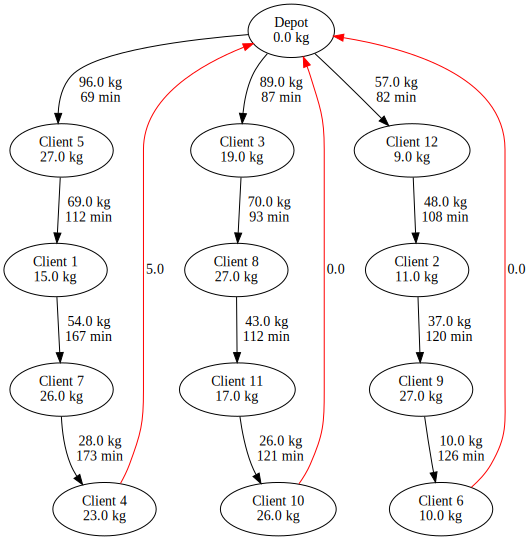

0.17532110214233398


In [157]:
visualize_solution(z_ij,x_ij)
print(model.Runtime)

In [22]:
l=[]
for i in y_i:
    l.append((i,y_i[i].x))
l.sort(key= lambda x:x[1])
l

[(0, 0.0),
 (18, 16.204999999999995),
 (4, 22.68559999999991),
 (12, 24.1699),
 (9, 44.296599999999984),
 (5, 62.0),
 (11, 68.0),
 (3, 69.0),
 (14, 82.0),
 (10, 84.34669999999994),
 (13, 91.0),
 (17, 96.0),
 (1, 98.0),
 (7, 98.206),
 (15, 99.0),
 (2, 102.172),
 (6, 103.61599999999999),
 (16, 104.43600000000004),
 (20, 110.57999999999984),
 (8, 111.24799999999999),
 (19, 115.88399999999984)]